In [1]:
import tensorflow as tf
import numpy as np
import math
import datetime
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras import mixed_precision, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_excel("dataset to be cleaned.xlsx")

df['time'] = pd.to_datetime(df['time'])
df = df.dropna(subset=['time'])
df = df.set_index('time').sort_index()

# Inspect sampling
dt = df.index.to_series().diff().value_counts().head(10)
print(dt)

# Fix time 
df.index = df.index.round('1min')
df = df[~df.index.duplicated(keep='first')]

# Negative -> NaN
cols_to_clean = ['Room Temp','RH','LP','HP','CO2','ETHYLENE_CLEAN']
for col in cols_to_clean:
    df.loc[df[col] < 0, col] = np.nan

# Spike removal 
median = df['ETHYLENE_CLEAN'].rolling(
    window=7, center=True, min_periods=1
).median()

mad = (df['ETHYLENE_CLEAN'] - median).abs().rolling(
    window=7, center=True, min_periods=1
).median()

df.loc[(df['ETHYLENE_CLEAN'] - median).abs() > 3*mad, 'ETHYLENE_CLEAN'] = np.nan

# Interpolate 
features_base = ['Room Temp','RH','LP','HP','CO2','ETHYLENE_CLEAN']
df[features_base] = df[features_base].interpolate(method='time', limit=2)

df[features_base] = df[features_base].ffill(limit=2).bfill(limit=2)


df['ETHYLENE_RATE'] = df['ETHYLENE_CLEAN'].diff()

features = features_base + ['ETHYLENE_RATE']
df = df[features].replace([np.inf, -np.inf], np.nan)
df = df.dropna()

data = df.copy()

time
0 days 00:00:59.995000    2325
0 days 00:01:00           1965
0 days 00:01:00.005000    1851
0 days 00:01:00.010000     479
0 days 00:03:59.980000      10
0 days 00:16:00.080000       4
0 days 00:15:00.075000       4
0 days 00:12:00.060000       4
0 days 00:20:00.100000       3
0 days 00:09:59.950000       3
Name: count, dtype: int64


<Axes: xlabel='time'>

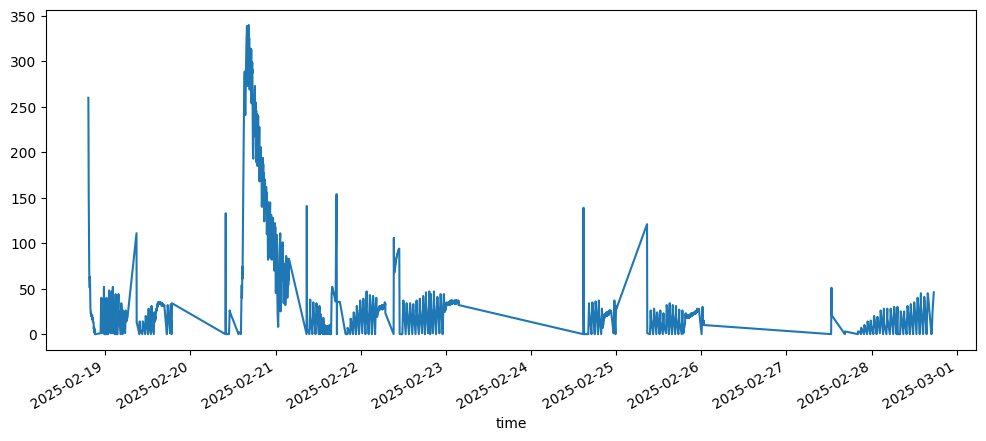

In [4]:
df['ETHYLENE_CLEAN'].plot(figsize=(12,5))

In [5]:
dataset = data.to_numpy(dtype='float32')
print(f"Rows: {dataset.shape[0]} Columns: {dataset.shape[1]}")

training_data_len = math.ceil(len(dataset) * 0.80)
print("Length of training data:", training_data_len)

train = data.iloc[:training_data_len]
test  = data.iloc[training_data_len:]

train_data = dataset[:training_data_len]
test_data  = dataset[training_data_len:]

print("Train data shape:", train_data.shape)
print("Test data shape :", test_data.shape)

Rows: 4252 Columns: 7
Length of training data: 3402
Train data shape: (3402, 7)
Test data shape : (850, 7)


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [7]:
x_training = []
y_training = []

WINDOW = 120
TARGET_COL = data.columns.get_loc("ETHYLENE_CLEAN")

for i in range(WINDOW, len(scaled_train_data)):
    x_training.append(scaled_train_data[i-WINDOW:i, :])   
    y_training.append(scaled_train_data[i, TARGET_COL])  

x_training = np.array(x_training)
y_training = np.array(y_training)

combined_test_data = np.vstack((
    scaled_train_data[-WINDOW:],
    scaled_test_data
))

x_test = []
y_test = []

for i in range(WINDOW, len(combined_test_data)):
    x_test.append(combined_test_data[i-WINDOW:i, :])
    y_test.append(combined_test_data[i, TARGET_COL])

x_test = np.array(x_test)
y_test = np.array(y_test)

In [8]:
print("X_train shape:", x_training.shape)
print("y_train shape:", y_training.shape)
print("X_test shape :", x_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (3282, 120, 7)
y_train shape: (3282,)
X_test shape : (850, 120, 7)
y_test shape : (850,)


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (WINDOW, 7)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss = 'mse',
    metrics = ['mae']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18432     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,545
Trainable params: 20,545
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',         
    patience=12,                
    restore_best_weights=True   
)

checkpoint = ModelCheckpoint(
    "best_lstm.h5",
    monitor="val_loss",
    save_best_only=True
)

In [11]:
history = model.fit(
    x_training,
    y_training,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks = [early_stop, checkpoint],
    verbose=1
)

Epoch 1/30
93/93 [==============================] - 7s 24ms/step - loss: 0.0412 - mae: 0.1178 - val_loss: 0.0041 - val_mae: 0.0570
Epoch 2/30
93/93 [==============================] - 2s 18ms/step - loss: 0.0322 - mae: 0.1036 - val_loss: 0.0017 - val_mae: 0.0244
Epoch 3/30
93/93 [==============================] - 2s 18ms/step - loss: 0.0391 - mae: 0.1237 - val_loss: 0.0016 - val_mae: 0.0198
Epoch 4/30
93/93 [==============================] - 2s 18ms/step - loss: 0.0317 - mae: 0.1013 - val_loss: 0.0016 - val_mae: 0.0186
Epoch 5/30
93/93 [==============================] - 2s 18ms/step - loss: 0.0291 - mae: 0.1056 - val_loss: 0.0022 - val_mae: 0.0303
Epoch 6/30
93/93 [==============================] - 2s 18ms/step - loss: 0.0242 - mae: 0.0907 - val_loss: 0.0013 - val_mae: 0.0171
Epoch 7/30
93/93 [==============================] - 2s 18ms/step - loss: 0.0172 - mae: 0.0795 - val_loss: 0.0012 - val_mae: 0.0144
Epoch 8/30
93/93 [==============================] - 2s 18ms/step - loss: 0.0128 - m

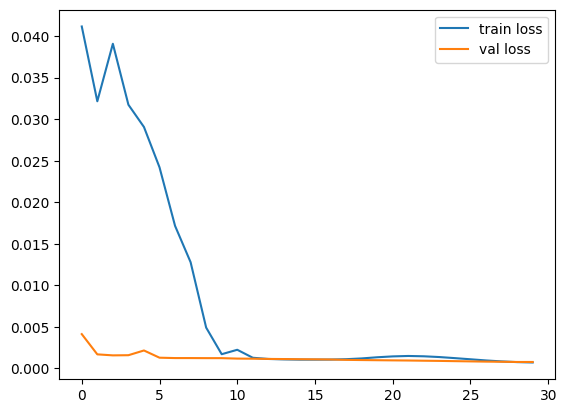

In [12]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [13]:
model.save("latest run.keras")

In [14]:
y_pred_scaled = model.predict(x_test)

27/27 [==============================] - 1s 7ms/step


In [15]:
eth_idx = data.columns.get_loc("ETHYLENE_CLEAN")

y_pred = []
y_true = []

for i in range(len(y_pred_scaled)):
    dummy = np.zeros((1, len(features)))

    # predicted
    dummy[0, eth_idx] = y_pred_scaled[i, 0]
    y_pred.append(scaler.inverse_transform(dummy)[0, eth_idx])

    # actual
    dummy[0, eth_idx] = y_test[i]
    y_true.append(scaler.inverse_transform(dummy)[0, eth_idx])

y_pred = np.array(y_pred)
y_true = np.array(y_true)

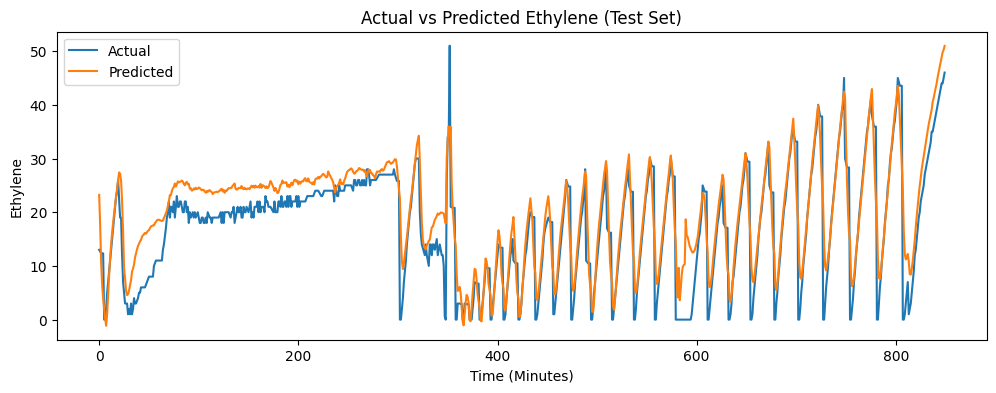

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.xlabel("Time (Minutes)")
plt.ylabel("Ethylene")
plt.title("Actual vs Predicted Ethylene (Test Set)")
plt.legend()
plt.show()

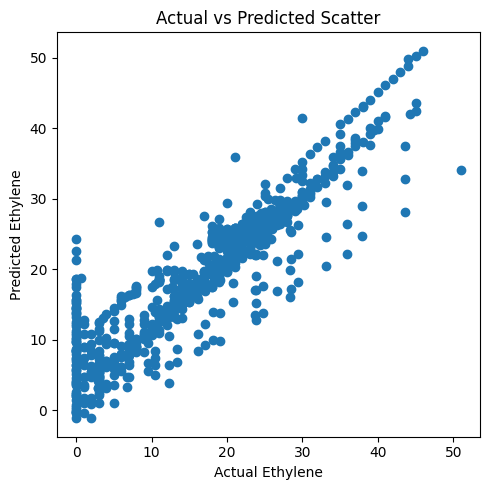

In [17]:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred)
plt.xlabel("Actual Ethylene")
plt.ylabel("Predicted Ethylene")
plt.title("Actual vs Predicted Scatter")
plt.tight_layout()
plt.show()

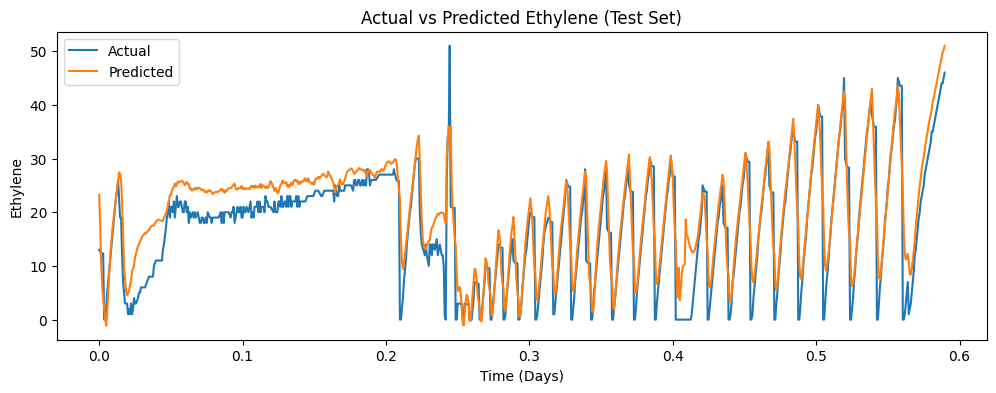

In [18]:
minutes = np.arange(len(y_true))
days = minutes / (60 * 24)

plt.figure(figsize=(12, 4))
plt.plot(days, y_true, label="Actual")
plt.plot(days, y_pred, label="Predicted")

plt.xlabel("Time (Days)")
plt.ylabel("Ethylene")
plt.title("Actual vs Predicted Ethylene (Test Set)")
plt.legend()
plt.show()


In [19]:
df['ETHYLENE_RATE_SMOOTH'] = (
    df['ETHYLENE_RATE']
    .rolling(window=5, min_periods=1)
    .mean()
)
rate_threshold = df['ETHYLENE_RATE_SMOOTH'].quantile(0.90)
print("Rate threshold:", rate_threshold)

positive_growth = df['ETHYLENE_RATE_SMOOTH'] > rate_threshold

df['GROWTH_RUN'] = positive_growth.rolling(
    window=30,     
    min_periods=30
).sum()

if (df['GROWTH_RUN'] == 30).any():
    ripening_onset_time = df.index[df['GROWTH_RUN'] == 30][0]
    print("Ripening onset detected at:", ripening_onset_time)
else:
    ripening_onset_time = None
    print("Ripening onset not detected.")

    
df['RIPENING_ONSET'] = 0

if ripening_onset_time is not None:
    df.loc[df.index >= ripening_onset_time, 'RIPENING_ONSET'] = 1


Rate threshold: 3.0
Ripening onset detected at: 2025-02-20 15:14:00


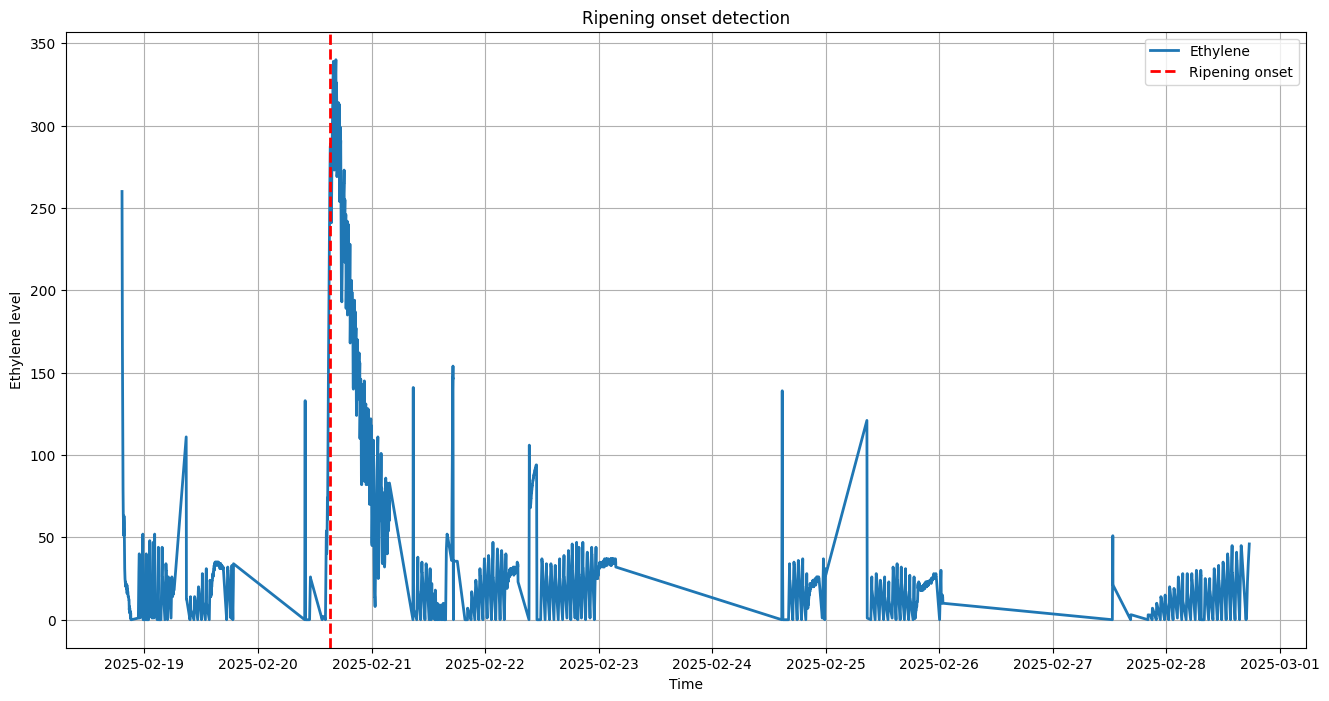

In [20]:
plt.figure(figsize=(16,8))
plt.plot(df.index, df['ETHYLENE_CLEAN'], label='Ethylene', linewidth=2)

if ripening_onset_time is not None:
    plt.axvline(
        ripening_onset_time,
        color='red',
        linestyle='--',
        linewidth=2,
        label='Ripening onset'
    )

plt.xlabel("Time")
plt.ylabel("Ethylene level")
plt.title("Ripening onset detection")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
model.save("tomato_ripening.keras")